# Homework 3

This is a homework assignment on the material from the 10th-15th classes. The deadline for submission is __23:59 on December 18__.

- The homework is done in the same Jupyter Notebook.

- The file should be renamed: __Group Number_First Name_Last Name__ (no spaces at the beginning or end). Example: __000_Ivan_Ivanov__.

- Homework should be sent to __OptimizationHomework@yandex.ru__. Subject line: __Innopolis_Task number__ (without spaces at the beginning and end). For this assignment, the subject line is: __Innopolis_3__.

- Place the solution to each problem/item after the condition.

- Do not forget to add necessary explanations and comments.

- All technical artifacts should be removed in the final version that will be sent for checking. By such artifacts we mean any cell outputs that are not commented in any way in the text, as well as any bulk/long technical output (even if it is commented in the text).

- A full run of the solution (Kernel -> Restart & Run All) should run all cells without errors.

- The maximum score for the assignment is 100.

We wish you success!

### Part 1. Solving the unconstrained optimization problem

Consider again the empirical risk minimization:
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ell (g(w, x_i), y_i) + \frac{\lambda}{2} \| w\|^2_2,
\end{equation}
where $\ell: \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ is a loss function, $g : \mathbb{R}^d \times \mathbb{R}^x \to \mathbb{R}$ is a model, $w$ are parameters of the model, $\{x_i, y_i\}_{i=1}^n$ is data of objects $x_i \in \mathbb{R}^x$ and labels $y_i \in \mathbb{R}$.

We use the linear model $g(w, x) = w^T x$ and the logistic/sigmoid loss function: $\ell(z,y) = \ln (1 + \exp(-yz))$ (__Important: $y$ must take values $-1$ or $1$__). As we already know, the resulting problem is called a logistic regression problem.

This problem can be rewritten as follows:
\begin{equation}
\min_{w \in \mathbb{R}^d} f(w) := \frac{1}{s} \sum\limits_{j=1}^s f_j(w) := \frac{1}{s} \sum\limits_{j=1}^s \left[\frac{1}{b} \sum\limits_{i=1}^b l (g(w, x_{(j-1)b + i}), y_{(j-1)b + i}) + \frac{\lambda}{2} \| w\|^2_2\right],
\end{equation}
where $b$ is the batch size, $s$ is the number of batches, and $b s = n$ is the total sample size.

The gradient of $f_j$:
$$
\nabla f_j(w) = \frac{1}{b} \sum_{i=1}^b \frac{-y_{(j-1)b + i} x_{(j-1)b + i}}{1 + \exp(y_{(j-1)b + i} w^Tx_{(j-1)b + i})}.
$$
The Lipschitz constant of the gradient $\nabla f_j$ can be estimated as $L_j = \frac{1}{4b} \sum\limits_{i=1}^b \| x_{(j-1)b + i} \|^2_2$.

Let us do some preparation work. The _mushrooms_ dataset is attached. Use the following code to generate a matrix $X$ and vector $y$, which will store the sample $\{x_i, y_i\}_{i=1}^n$:

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
from tqdm import trange
from tqdm import tqdm
from IPython.display import clear_output
sns.set_theme()

In [2]:
dataset = "mushrooms.txt" 
#the file must be in the same directory as notebook.

In [3]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

Let us change the vector $y$ so that $y_i$ takes values $-1$ and $1$. You can also do additional preprocessing of the data (with techniques from machine learning), but this is not additionally assessed in any way.

In [4]:
y = 2 * y - 3

Let us divide the data into two parts: train and test.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

For $X_{train}$, $y_{train}$, estimate the constant $L$. Set $\lambda$ such that $\lambda \approx L / 1000$.  Realize in the code the calculation of the value and gradient of $f$ ($X$, $y$, $\lambda$ should be given as a parameter so that it is possible to change them).

In [6]:
def f(X : np.ndarray, y : np.ndarray, w : np.ndarray, lam):
    n = X.shape[0]
    f = 0
    for i in range(n):
        f += np.log(1 + np.exp(-y[i] * (w.transpose() @ X[i])))
    return f / n + 0.5 * lam * np.linalg.norm(w)**2

In [7]:
def grad(X : np.ndarray, y : np.ndarray, w : np.ndarray, lam):
    n = X.shape[0]
    gr = np.zeros(X.shape[1]).reshape(-1,1)
    for i in range(n):
        gr += (y[i] * X[i].reshape(-1,1)) / ( 1 + np.exp(y[i] * (w.transpose() @ X[i])))
    return -gr / n + lam * w

In [39]:
def grad_without_R(X : np.ndarray, y : np.ndarray, w : np.ndarray):
    n = X.shape[0]
    gr = np.zeros(X.shape[1]).reshape(-1,1)
    for i in range(n):
        gr += (y[i] * X[i].reshape(-1,1)) / ( 1 + np.exp(y[i] * (w.transpose() @ X[i])))
    return -gr / n

In [134]:
x_0 = np.ones((X_train.shape[1], 1))

In [9]:
def calculate_accuracy(X, y, x):
    corrected = 0
    total = X.shape[0]
    for i in range(X.shape[0]):
        prediction = x.T @ X[i]
        true = y[i]
        if true * prediction > 0:
            corrected+=1
    return corrected / total

In [10]:
sum = 0
for i in range(X_train.shape[0]):
    sum += np.linalg.norm(X_train[i])**2
sum = sum / 4 / X_train.shape[0]
print(f"Lipschitz constant is {sum} + lambda")

Lipschitz constant is 5.25 + lambda


So lambda is 0.00525

In [11]:
lam = 0.00525

In [12]:
def calculate_L_for_batch(X : np.ndarray, lam):
    sum = 0
    for i in range(X.shape[0]):
        sum += np.linalg.norm(X[i])**2
    sum = sum / 4 / X.shape[0]
    return sum + lam

__Problem 0. (5 points)__  Implement the ability to uniformly divide the training part of the dataset into batches of size $b$ ($b$ is a parameter).

In [13]:
#your solution (Code and Markdown)
def divide_into_batches(X, y, b):
    # Returns to lists with batches
    return np.array_split(X, np.ceil(len(X) / b)), np.array_split(y, np.ceil(len(y) / b))

__Problem 1. (50 points)__ This part of the assignment is related to __non-distributed stochastic__ methods.

__a). (5 points)__ Implement the SGD method:
$$
w^{k+1} = w^k - \gamma_k \nabla f_{j_k} (w^k),
$$
where the number $j_k$ is generated independently and uniformly from $\{1, \ldots, s \}$.

Just in case, we give here a variant of the function description for the gradient descent from the first assignment. You can use this format if you wish. Note that ``x_sol`` occurs in the code - this problem should be solved or criteria tied to ``x_sol`` should not be used.

In [19]:
def gradient_descent(X_buckets, y_buckets, X_train, y_train, f, nabla_f, x_0, lam, args,
                     K = 10**3, eps = 10**-5):
    '''
        f - target function
        nabla_f - gradient of the target function
        x_0 - start point
        gamma_k - function for calculating the method step
        lam - value of regularization parameter
        K - number of iterations (by default 1e3)
        eps - accuracy (by default 1e-5)

        The function returns the point at which the minimum is reached and the error vector
    '''
    x_k = x_0.copy()
    norm_grad_at_x_0 = np.linalg.norm(nabla_f(X_train, y_train, x_0, lam))
    errors = [1]
    accuracies = [0.5]
    gradients_calculated = [0]
    s = len(y_buckets)
    for k in range(K):
        j = random.randint(0, s-1)
        if args["type"] == "L":
            L = calculate_L_for_batch(X_buckets[j], lam)
            step = 1 / L
        elif args["type"] == "const":
            step = args["const"]
        elif args["type"] == "3":
            step = 1 / math.sqrt(k+1)
        elif args["type"] == "4":
            step = 1 / (k+1)
        else:
            raise Exception("no such type")
        grad = nabla_f(X_buckets[j], y_buckets[j], x_k, lam)
        x_k -= step * grad
        if args["accuracy"]:
            accuracies.append(calculate_accuracy(X_test, y_test, x_k))
        gradients_calculated.append(gradients_calculated[-1] + X_buckets[j].shape[0])
        norm_grad_for_total = np.linalg.norm(nabla_f(X_train, y_train, x_k, lam))
        error = norm_grad_for_total / norm_grad_at_x_0
        errors.append(error)
        if error < eps:
            break
        if error > 4:
            break
    if args["accuracy"]:
        return x_k, errors, accuracies, gradients_calculated
    return x_k, errors, gradients_calculated

__b). (7 points)__ Solve the optimization problem on the training sample using the implemented method. Take $b = 10$, and the step is $\gamma_k \equiv \frac{1}{\tilde L}$. From the point of view of the theory, what should be taken as $\tilde L$? Draw the convergence plot: the value of the convergence criterion ($\frac{\| \nabla f(w^k)\|}{\| \nabla f(w^0)\|}$) from the iteration number. Make a conclusion.

## Answer to the question
From the point of view of the theory, L with hat should be takes as the L for the batch.

In [15]:
#your solution (Code and Markdown)
b = 10
X_buckets, y_buckets = divide_into_batches(X_train, y_train, b)
args = {
    "type" : "L",
    "accuracy" : False
}
x_k, errors = gradient_descent(X_buckets, y_buckets, X_train, y_train, f, grad, x_0, lam, args, K = 300)

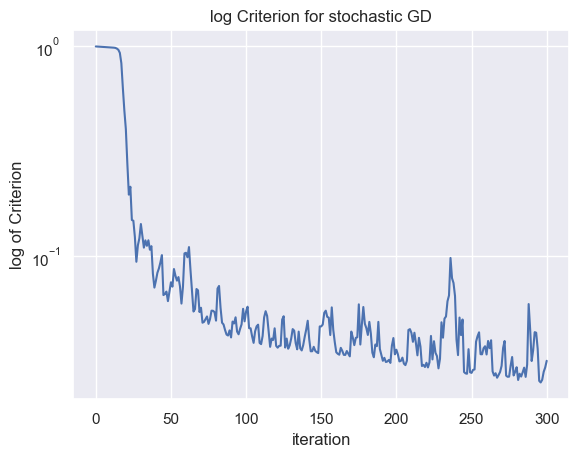

In [16]:
plt.plot(range(len(errors)), errors)
plt.title("log Criterion for stochastic GD")
plt.xlabel("iteration")
plt.ylabel("log of Criterion")
plt.yscale("log")

## Conclusion
1. It has a big fall after ~15 iteration
2. It has a visible variance after ~23 iteration, we see this by oscillations and jumps
3. The convergence becomes slow after around 15th iteration (remember that yscale is logarythmic)

__c). (7 points)__ Vary the batch size: $b = 1, 10, 100, 1000$, and take the step size equal to $\gamma_k \equiv \frac{1}{\tilde L}$ (note that $\tilde L$ need to be recalculated for each $b$). Draw the convergence plot: the value of the convergence criterion from the iteration number for each $b$. Does this plot reflect a fair comparison? Why? Figure out how to compare the results to each other more honestly (running time is a good option, but you can't use it here) and draw a new comparison plot. Make a conclusion.

## Answer to the question
The comparison is not fair, since for every bucket size we have different number of gradient calculations before taking step. Therefore, we can have equal results in terms of number of iterations, but the calculations can differ much.

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.03s/it]


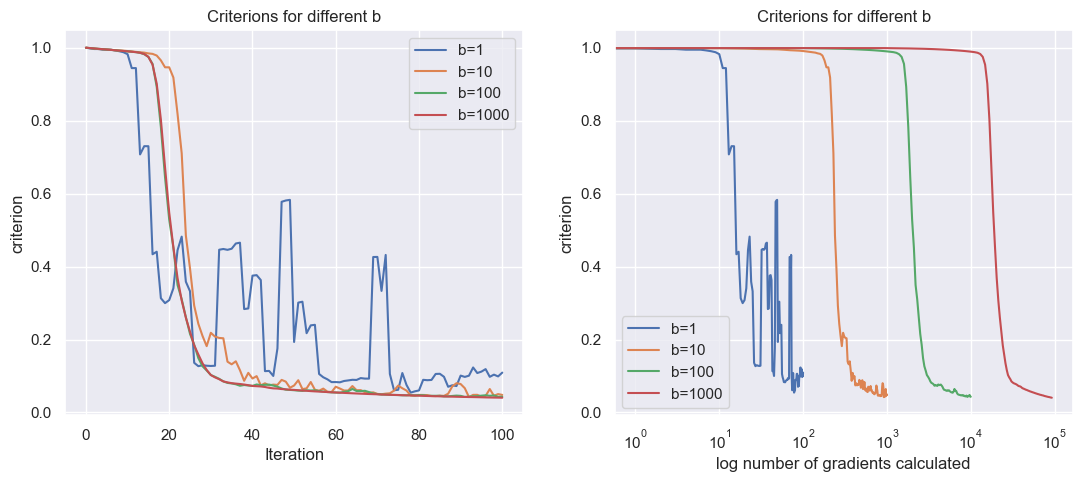

In [21]:
#your solution (Code and Markdown)
f, axes = plt.subplots(1,2, figsize=(13,5))
axes[0].set_title("Criterions for different b")
axes[1].set_title("Criterions for different b")
axes[0].set_xlabel("Iteration")
axes[1].set_xlabel("log number of gradients calculated")
axes[1].set_xscale("log")
axes[0].set_ylabel("criterion")
axes[1].set_ylabel("criterion")

bs = [1,10,100,1000]
for b in tqdm(bs):
    X_buckets, y_buckets = divide_into_batches(X_train, y_train, b)
    args = {
    "type" : "L",
    "accuracy" : False
    }
    x_k, errors, gradients = gradient_descent(X_buckets, y_buckets, X_train, y_train, f, grad, x_0, lam, args, K = 100)
    axes[0].plot(range(len(errors)), errors)
    axes[1].plot(gradients, errors)
    
axes[0].legend(["b=1", "b=10", "b=100", "b=1000"])
axes[1].legend(["b=1", "b=10", "b=100", "b=1000"])

## Conclusion
Here we see, that:
1. Using less number of buckets leads to higher variance
2. The performance in terms of iterations is almost the same for b=10,100,1000, at 100 iteration we have almost same values.
3. However, in terms of gradient computations to achieve some error is very different. We see that even though b=10,100,1000 achieve the same performance, b=10 takes 10 times less number of computations than b=100, and b=100 takes 10 times less computations than b=1000.
As a result, b=10 seems to be the best option but a little bit noisy, and b=100 seems good in terms of both variance and gradient calculations

__d). (6 points)__ Let us fix $b = 10$ and try to change the strategy of choosing the step:

1) $\gamma_k \equiv \frac{1}{\tilde L}$ as we did before,

2) $\gamma_k \equiv \text{const}$, selecting $\text{const}$ to get the "best" convergence (explain what you mean by "best"),

3) $\gamma_k = \frac{1}{\sqrt{k + 1}}$, 

4) $\gamma_k = \frac{1}{k + 1}$.

Draw the convergence plot: the value of the convergence criterion from the iteration number. Make a conclusion.

In [27]:
b = 10
X_buckets, y_buckets = divide_into_batches(X_train, y_train, b)

In [28]:
args = {
    "type" : "L",
    "accuracy" : False
}
_, errorsL = gradient_descent(X_buckets, y_buckets, X_train, y_train, f, grad, x_0, lam, args, K = 300)

In [29]:
args = {
    "type" : "3",
    "accuracy" : False
}
_, errors3 = gradient_descent(X_buckets, y_buckets, X_train, y_train, f, grad, x_0, lam, args, K = 300)

In [30]:
args = {
    "type" : "4",
    "accuracy" : False
}
_, errors4 = gradient_descent(X_buckets, y_buckets, X_train, y_train, f, grad, x_0, lam, args, K = 300)

In [31]:
consts = [0.1, 0.5, 1]
errors_for_consts = []
for c in consts:
    args = {
        "type" : "const",
        "const": c,
        "accuracy" : False
    }
    _, errors = gradient_descent(X_buckets, y_buckets, X_train, y_train, f, grad, x_0, lam, args, K = 300)
    errors_for_consts.append(errors)

Text(0, 0.5, 'Criterion')

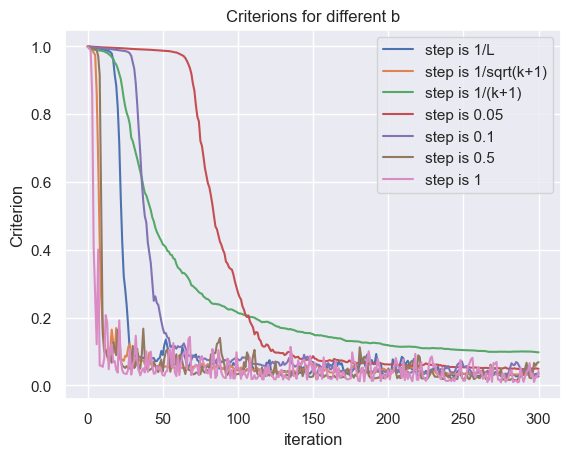

In [32]:
plt.plot(range(len(errorsL)), errorsL)
plt.plot(range(len(errors3)), errors3)
plt.plot(range(len(errors4)), errors4)
plt.plot(range(len(errors_for_consts[0])), errors_for_consts[0])
plt.plot(range(len(errors_for_consts[1])), errors_for_consts[1])
plt.plot(range(len(errors_for_consts[2])), errors_for_consts[2])
plt.plot(range(len(errors_for_consts[3])), errors_for_consts[3])
plt.legend(["step is 1/L", "step is 1/sqrt(k+1)", "step is 1/(k+1)","step is 0.1", "step is 0.5", "step is 1"])
plt.title("Criterions for different steps")
plt.xlabel("iteration")
plt.ylabel("Criterion")

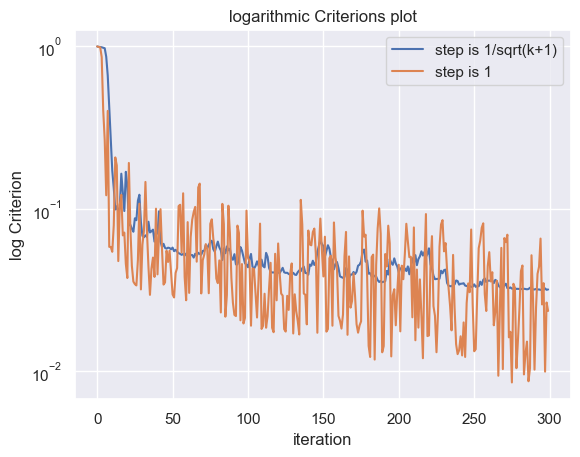

In [33]:
plt.plot(range(len(errors3[:300])), errors3[:300])
plt.plot(range(len(errors_for_consts[3][:300])), errors_for_consts[3][:300])
plt.legend(["step is 1/sqrt(k+1)","step is 1"])
plt.title("logarithmic Criterions plot")
plt.xlabel("iteration")
plt.ylabel("log Criterion")
plt.yscale("log")

## Conclusion
1. The best option seems to be using the step function 1 / (sqrt(k+1)). It converges very fast to the neighborhood and gives much lower variance in comparison to constant step size equal to 1, even though constant step size 1 gives the same speed of convergence to the neighborhood
2. Stepsize 1/(k+1) converges slowly and takes very small value too fast
3. small stepsizes provide higher convergence rate but lower variance
4. After 15th iteration the convergence becomes very slow

__e). (5 points)__ In the previous hometask, we used the obtained solution of the optimization problem to predict answers on a test sample. Recall the essence: the original regression problem is a machine learning problem and using a linear model $g$ we can predict the values of labels $y$. Suppose we have a sample $x_i$, the model response for this sample is $g(w^*, x^i)$. Then the predictive rule can be formulated in the following rather natural way:
$$
y_i = 
\begin{cases}
1, & g(w^*, x^i) \geq 0,
\\
-1, & g(w^*, x^i) < 0.
\end{cases}
$$
By making predictions on the test sample $X_{test}$, we can compare the result with the real labels $y_{test}$. The number of correctly guessed labels is the accuracy of the model.

Look at the accuracy of the model trained with SGD. Repeat point c)-d), but now plot the accuracy dependence, not the convergence criterion. Make a conclusion.

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.28s/it]


Text(0, 0.5, 'accuracy')

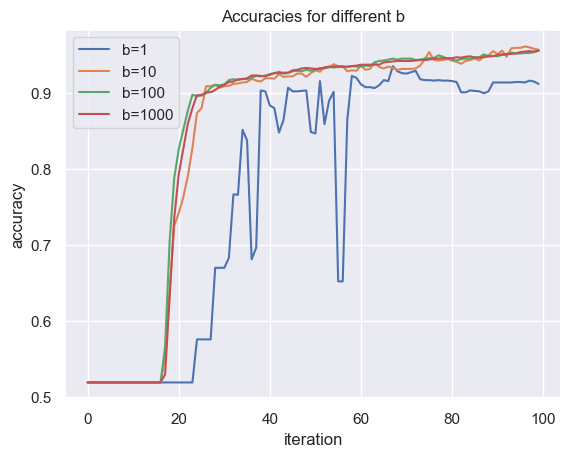

In [114]:
bs = [1,10,100,1000]
for b in tqdm(bs):
    X_buckets, y_buckets = divide_into_batches(X_train, y_train, b)
    args = {
    "type" : "L",
    "accuracy" : True
    }
    x_k, losses, accuracies = gradient_descent(X_buckets, y_buckets, X_train, y_train, f, grad, x_0, lam, args, K = 100)
    plt.plot(range(len(accuracies)), accuracies)
plt.legend(["b=1", "b=10", "b=100", "b=1000"])
plt.title("Accuracies for different b")
plt.xlabel("iteration")
plt.ylabel("accuracy")

## Conclusion
We see here that accuracy behaves quite similar to criterion.
for lower sizes of buckets we see higher variance in values.
Also, there is jump in accuracy at 17th iteration.
Lastly, for values 10,100,1000 is almost identical

In [104]:
b = 10
X_batches, y_batches = divide_into_batches(X_train, y_train, b)

In [108]:
args = {
    "type" : "L",
    "accuracy" : True
}
_, _,errorsL = gradient_descent(X_batches, y_batches, X_train, y_train, f, grad, x_0, lam, args, K = 100)

In [109]:
args = {
    "type" : "3",
    "accuracy" : True
}
_, _,errors3 = gradient_descent(X_batches, y_batches, X_train, y_train, f, grad, x_0, lam, args, K = 100)

In [110]:
args = {
    "type" : "4",
    "accuracy" : True
}
_, _,errors4 = gradient_descent(X_batches, y_batches, X_train, y_train, f, grad, x_0, lam, args, K = 100)

In [111]:
consts = [0.1, 0.5, 1]
errors_for_consts = []
for c in consts:
    args = {
        "type" : "const",
        "const": c,
        "accuracy" : True
    }
    _, _,errors = gradient_descent(X_batches, y_batches, X_train, y_train, f, grad, x_0, lam, args, K = 100)
    errors_for_consts.append(errors)

Text(0, 0.5, 'Accuracy')

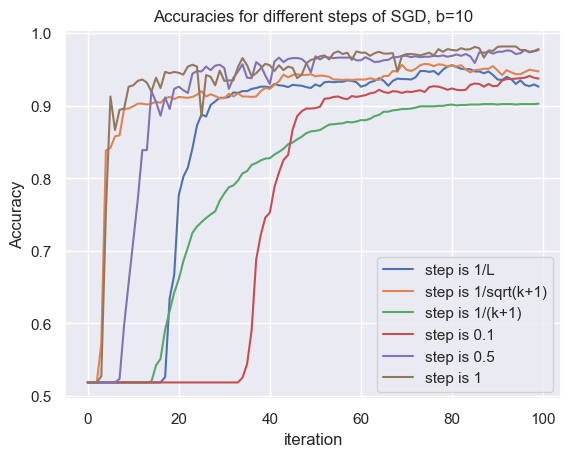

In [115]:
plt.plot(range(len(errorsL)), errorsL)
plt.plot(range(len(errors3)), errors3)
plt.plot(range(len(errors4)), errors4)
plt.plot(range(len(errors_for_consts[0])), errors_for_consts[0])
plt.plot(range(len(errors_for_consts[1])), errors_for_consts[1])
plt.plot(range(len(errors_for_consts[2])), errors_for_consts[2])
plt.legend(["step is 1/L", "step is 1/sqrt(k+1)", "step is 1/(k+1)","step is 0.1", "step is 0.5", "step is 1"])
plt.title("Accuracies for different steps of SGD, b=10")
plt.xlabel("iteration")
plt.ylabel("Accuracy")

## Conclusion
As in case of criterion, step of 1 and $\frac{1}{\sqrt{k+1}}$ are the best, the converge fast, but step of 1 achieves better results unlike $\frac{1}{\sqrt{k+1}}$\
Also, step of 0.5 achieves the same best result, but later.\
The step $\frac{1}{k+1}$ is very bad as always, as well as constant step 0.1.\
$\frac{1}{L}$ is the good option from theory.

__f). (30 points)__ Implement the SAGA (Section A.5 of [paper](https://arxiv.org/pdf/1905.11261.pdf)), SVRG (Section А.9 from [работы](https://arxiv.org/pdf/1905.11261.pdf)) and SARAH ([работа](https://arxiv.org/pdf/1703.00102.pdf)) methods for our problem. Solve the optimization problem on the training sample using the new implemented methods. Take $b = 10$, and hyperparameters of methods according to the theory (see corresponding papers). Write these parameters. Is the iteration number a fair for comparison of these methods? Figure out how to compare the results more honestly (running time is a good option, but you can't use it here). Draw the comparison plots of SGD (with step $\gamma_k \equiv \frac{1}{\tilde L}$), SAGA, SVRG and SARAH: 1) value of convergence criterion versus your criterion, 2) accuracy of predictions versus your criterion. Make a conclusion.

In [157]:
b = 10
X_batches, y_batches = divide_into_batches(X_train, y_train, b)

## SAGA
Learning rate is chosen to be $\frac{1}{\sqrt{k+1}}$

In [28]:
def proximal_for_L2_squared(w : np.ndarray, lam, lr = 1):
  '''
  alpha - the stepsize for proximal operator
  lambda - the coefficient for regularizer

  Returns the result of proximal step
  '''
  return w / (1 + lam * lr)

In [46]:
def SAGA(X_batches, y_batches, X_train, y_train, x_0, lam, args,
                     K = 10**3, eps = 10**-5):
    x_k = x_0.copy()
    norm_grad_at_x_0 = np.linalg.norm(grad(X_train, y_train, x_0, lam))
    errors = [1]
    accuracies = [0.5]
    gradients_calculated=[0]
    s = len(X_batches)
    phis = np.stack([x_0.copy() for i in range(s)])
    L_for_batches = [calculate_L_for_batch(X_batches[worker], lam) for worker in range(s)]
    
    for k in trange(K):
        j = random.randint(0, s-1)
        
        if args["type"] == "L":
            step = 1 / L_for_batches[j]
        elif args["type"] == "const":
            step = args["const"]
        elif args["type"] == "3":
            step = 1 / math.sqrt(k+1)
        elif args["type"] == "4": 
            step = 1 / (k+1)
        else:
            raise Exception("no such type")
            
        g = grad_without_R(X_batches[j], y_batches[j], x_k) - grad_without_R(X_batches[j], y_batches[j], phis[j]) + np.add.reduce([grad_without_R(X_batches[i], y_batches[i], phis[i]) for i in range(s)]) / s
        phis[j] = x_k.copy()
        x_k -= step * g
        x_k = proximal_for_L2_squared(x_k, lam, step)
        
        gradients_calculated.append(gradients_calculated[-1] + X_train.shape[0] + X_batches[j].shape[0] * 2)
        if args["accuracy"]:
            accuracies.append(calculate_accuracy(X_test, y_test, x_k))
        norm_grad_for_total = np.linalg.norm(grad(X_train, y_train, x_k, lam))
        error = norm_grad_for_total / norm_grad_at_x_0
        errors.append(error)
        if error < eps:
            break
        if error > 4:
            break
    if args["accuracy"]:
        return x_k, errors, accuracies, gradients_calculated
    return x_k, errors, gradients_calculated

In [138]:
args = {
    "type" : "3",
    "accuracy" : True
}
_, errorsSAGA, accuraciesSAGA, gradients_calculatedSAGA = SAGA(X_batches, y_batches, X_train, y_train, x_0, lam, args, K = 300)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:33<00:00,  9.08it/s]


## SVRG 
The only hyperparameter here is m - the maximum number of iterations in innerloop. Paper suggested to use m close to the number of samples in the dataset.\
The original paper proposed to sample m every iteration, therefore parameter m is the MAXIMUM possible number of iterations in inner loop
learning rate is chosen to be $\frac{1}{\sqrt{k+1}}$

In [140]:
def SVRG(X_batches, y_batches, X_train, y_train, x_0, lam, args,
                     K = 100,M = 150, eps = 10**-5):
    x_0 = x_0.copy()
    norm_grad_at_x_0 = np.linalg.norm(grad(X_train, y_train, x_0, lam))
    errors = [1]
    accuracies = [0.5]
    gradients_calculated = [0]
    s = len(X_batches)
    phi = x_0.copy()
    L_for_batches = [calculate_L_for_batch(X_batches[worker], lam) for worker in range(s)]
    
    for k in trange(K):
        if args["type"] == "const":
            step = args["const"]
        elif args["type"] == "3":
            step = 1 / math.sqrt(k+1)
        elif args["type"] == "4": 
            step = 1 / (k+1)
        elif args["type"] != "L":
            raise Exception("no such type")

        mu = grad_without_R(X_train, y_train, phi)
        x_k_list = []
        gradients_counter = X_train.shape[0]
        m_cur = np.random.randint(1, M)
        
        for b in range(m_cur): # from original paper about svrg
            sampled_i = np.random.randint(0, s)
            if args["type"] == "L":
                step = 1 / L_for_batches[sampled_i]
            
            g = grad_without_R(X_batches[sampled_i], y_batches[sampled_i], x_0) - grad_without_R(X_batches[sampled_i], y_batches[sampled_i], phi) + mu
            x_0 -= step * g
            x_0 = proximal_for_L2_squared(x_0, lam, step)
            x_k_list.append(x_0.copy())
            gradients_counter += X_batches[sampled_i].shape[0]
            
        phi = x_0 =  np.add.reduce(x_k_list) / m_cur

        gradients_calculated.append(gradients_calculated[-1] + gradients_counter)
        if args["accuracy"]:
            accuracies.append(calculate_accuracy(X_test, y_test, phi))
            
        norm_grad_for_total = np.linalg.norm(grad(X_train, y_train, phi, lam))
        error = norm_grad_for_total / norm_grad_at_x_0
        errors.append(error)
        if error < eps:
            break
        if error > 4:
            break
            
    if args["accuracy"]:
        return phi, errors, accuracies, gradients_calculated
    return phi, errors, gradients_calculated

In [141]:
args = {
    "type" : "3",
    "accuracy" : True
}
_, errorsSVRG, accuraciesSVRG, gradients_calculatedSVRG = SVRG(X_batches, y_batches, X_train, y_train, x_0, lam, args, K = 300, M = len(X_batches))

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:44<00:00,  6.67it/s]


# SARAH (+)

## Hyperparameters
Here we have only one tunable hyperparameter except learning rate: m - number of iterations in the inner loops.
I have implemented SARAH+ that controls number of iterations in inner loop by itself. The only thing paper states is to make sure m(now it is a maximum number of iterations of inner loop) is large enough for robustness, like the number of samples/batches. So m is the number of batches
The learning rate is chosen to be $\frac{1}{\sqrt{k+1}}$

In [143]:
def SARAH(X_batches, y_batches, X_train, y_train, x_0, lam, args,
                     K = 300,m = 50, eps = 10**-5):
    x_0 = x_0.copy()
    x_tilda = x_0.copy()
    norm_grad_at_x_0 = np.linalg.norm(grad(X_train, y_train, x_0, lam))
    errors = [1]
    accuracies = [0.5]
    gradients_calculated=[0]
    s = len(X_batches)

    for k in trange(K):
        x_0 = x_tilda.copy()
        
        v_0 = grad(X_train, y_train, x_0, lam)
        v_t = v_0.copy()
        
        if args["type"] == "const":
            step = args["const"]
        elif args["type"] == "3":
            step = 1 / math.sqrt(k+1)
        elif args["type"] == "4": 
            step = 1 / (k+1)
        else:
            raise Exception("no such type")

        x_1 = x_0 - step * v_t
        t = 1
        gradients_counter = X_train.shape[0] #from v_0
        
        while np.linalg.norm(v_t)**2 > step * np.linalg.norm(v_0)**2 and t < m:
            sampled_i = np.random.randint(0, s)
            
            v_t = grad(X_batches[sampled_i], y_batches[sampled_i], x_1, lam) - grad(X_batches[sampled_i], y_batches[sampled_i], x_0, lam) + v_t
            x_0 = x_1
            x_1 = x_1 - step * v_t
            t+=1
            gradients_counter += X_batches[sampled_i].shape[0] * 2
            
        x_tilda = x_1

        gradients_calculated.append(gradients_calculated[-1] + gradients_counter)
        if args["accuracy"]:
            accuracies.append(calculate_accuracy(X_test, y_test, x_tilda))
            
        norm_grad_for_total = np.linalg.norm(grad(X_train, y_train, x_tilda, lam))
        error = norm_grad_for_total / norm_grad_at_x_0
        errors.append(error)
        if error < eps:
            break
        if error > 4:
            break
            
    if args["accuracy"]:
        return x_tilda, errors, accuracies, gradients_calculated
    return x_tilda, errors, gradients_calculated

In [144]:
args = {
    "type" : "3",
    "accuracy" : True
}
_, errorsSARAH, accuraciesSARAH, gradients_calculatedSARAH = SARAH(X_batches, y_batches, X_train, y_train, x_0, lam, args, K = 300, m = len(X_batches))

  6%|████▊                                                                            | 18/300 [00:02<00:43,  6.55it/s]


#### for SGD

In [147]:
args = {
    "type" : "L",
    "accuracy" : True
}
_, errorsSGD, accuraciesSGD, gradients_calculatedSGD = gradient_descent(X_buckets, y_buckets, X_train, y_train, f, grad, x_0, lam, args, K = 100)

## The plot of criterion for number of computed gradients

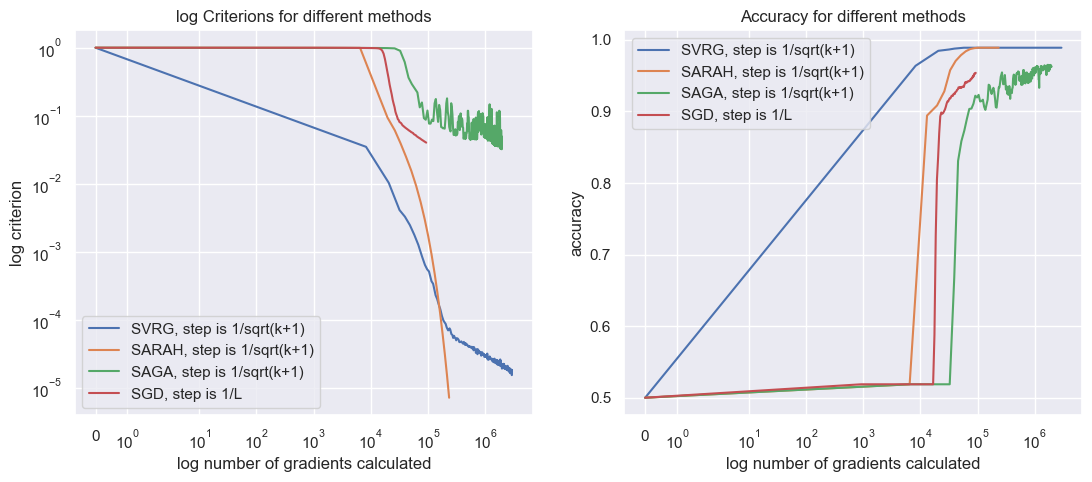

In [148]:
f, axes = plt.subplots(1,2, figsize=(13,5))
axes[0].set_title("log Criterions for different methods")
axes[1].set_title("Accuracy for different methods")
axes[0].set_xlabel("log number of gradients calculated")
axes[1].set_xlabel("log number of gradients calculated")
axes[0].set_yscale("log")
axes[0].set_ylabel("log criterion")
axes[1].set_ylabel("accuracy")

axes[0].plot(gradients_calculatedSVRG, errorsSVRG)
axes[1].plot(gradients_calculatedSVRG, accuraciesSVRG)
axes[0].plot(gradients_calculatedSARAH, errorsSARAH)
axes[1].plot(gradients_calculatedSARAH, accuraciesSARAH)
axes[0].plot(gradients_calculatedSAGA, errorsSAGA)
axes[1].plot(gradients_calculatedSAGA, accuraciesSAGA)
axes[0].plot(gradients_calculatedSGD, errorsSGD)
axes[1].plot(gradients_calculatedSGD, accuraciesSGD)
axes[0].set_xscale("symlog")
axes[1].set_xscale("symlog")
axes[0].legend(["SVRG, step is 1/sqrt(k+1)", "SARAH, step is 1/sqrt(k+1)", "SAGA, step is 1/sqrt(k+1)", "SGD, step is 1/L"])
axes[1].legend(["SVRG, step is 1/sqrt(k+1)", "SARAH, step is 1/sqrt(k+1)", "SAGA, step is 1/sqrt(k+1)", "SGD, step is 1/L"])

## Conclusion
1. We see that SAGA has problems with convergence and variance, and takes a lot of calculations to slowly converge
2. SGD also converges relatively slow, even though variance is much lower
3. SVRG and SARAH converge almost immidiately in terms of iterations, but every iteration takes a lot of gradient computations
4. The fastest convergence in first iterations in terms of gradient calculations has been shown by SVRG
5. However, SVRG could not achieve the criterion of 0.00001, but SARAH could.
6. Also, SARAH has much better convergence after some time than SVRG
7. Finally, we see that in terms of gradient calculations, SVRG and SARAH are much better than SGD with step 1/L

As in d.2), find the "best" step for SAGA, SVRG, SARAH. Draw the comparison plots for SGD, SAGA, SVRG, SARAH with the "best" steps: 1) convergence criterion value, 2) prediction accuracy. Make a conclusion.

Text(0, 0.5, 'Criterion')

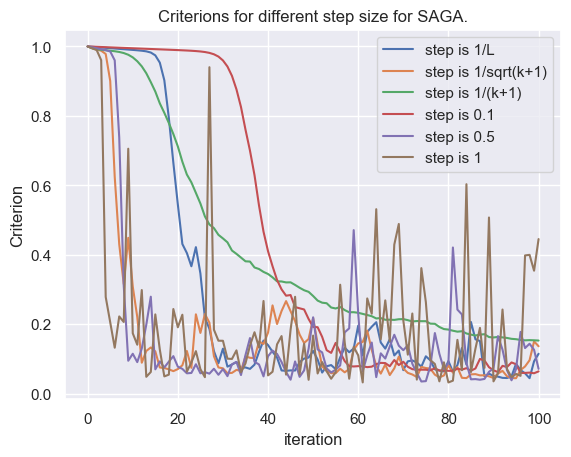

In [149]:
args = {
    "type" : "L",
    "accuracy" : True
}
_, errorsL, accuraciesL, _ = SAGA(X_batches, y_batches, X_train, y_train, x_0, lam, args, K = 100, eps=1e-3)
args = {
    "type" : "3",
    "accuracy" : True
}
_, errors3, accuracies3, _ = SAGA(X_batches, y_batches, X_train, y_train, x_0, lam, args, K = 100, eps=1e-3)
args = {
    "type" : "4",
    "accuracy" : True
}
_, errors4, accuracies4, _ = SAGA(X_batches, y_batches, X_train, y_train, x_0, lam, args, K = 100, eps=1e-3)

consts = [0.1, 0.5, 1]
errors_for_consts = []
for c in consts:
    args = {
        "type" : "const",
        "const": c,
        "accuracy" : True
    }
    _, errors, accuracies, _ = SAGA(X_batches, y_batches, X_train, y_train, x_0, lam, args, K = 100, eps=1e-3)
    errors_for_consts.append(errors)
    
clear_output()
plt.plot(range(len(errorsL)), errorsL)
plt.plot(range(len(errors3)), errors3)
plt.plot(range(len(errors4)), errors4)
plt.plot(range(len(errors_for_consts[0])), errors_for_consts[0])
plt.plot(range(len(errors_for_consts[1])), errors_for_consts[1])
plt.plot(range(len(errors_for_consts[2])), errors_for_consts[2])
plt.legend(["step is 1/L", "step is 1/sqrt(k+1)", "step is 1/(k+1)", "step is 0.1", "step is 0.5", "step is 1"])
plt.title("Criterions for different step size for SAGA.")
plt.xlabel("iteration")
plt.ylabel("Criterion")

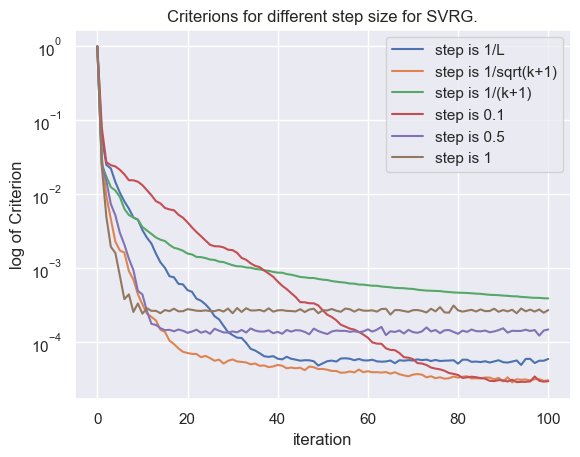

In [150]:
args = {
    "type" : "L",
    "accuracy" : True
}
_, errorsL, accuraciesL, _ = SVRG(X_batches, y_batches, X_train, y_train, x_0, lam, args, K = 100, M = len(X_batches))
args = {
    "type" : "3",
    "accuracy" : True
}
_, errors3, accuracies3, _ = SVRG(X_batches, y_batches, X_train, y_train, x_0, lam, args, K = 100, M = len(X_batches))
args = {
    "type" : "4",
    "accuracy" : True
}
_, errors4, accuracies4, _ = SVRG(X_batches, y_batches, X_train, y_train, x_0, lam, args, K = 100, M = len(X_batches))

consts = [0.1, 0.5, 1]
errors_for_consts = []
for c in consts:
    args = {
        "type" : "const",
        "const": c,
        "accuracy" : True
    }
    _, errors, accuracies, _ = SVRG(X_batches, y_batches, X_train, y_train, x_0, lam, args, K = 100, M = len(X_batches))
    errors_for_consts.append(errors)

clear_output()
plt.plot(range(len(errorsL)), errorsL)
plt.plot(range(len(errors3)), errors3)
plt.plot(range(len(errors4)), errors4)
plt.plot(range(len(errors_for_consts[0])), errors_for_consts[0])
plt.plot(range(len(errors_for_consts[1])), errors_for_consts[1])
plt.plot(range(len(errors_for_consts[2])), errors_for_consts[2])
plt.legend(["step is 1/L", "step is 1/sqrt(k+1)", "step is 1/(k+1)", "step is 0.1", "step is 0.5", "step is 1"])
plt.title("Criterions for different step size for SVRG.")
plt.xlabel("iteration")
plt.ylabel("log of Criterion")
plt.yscale("log")

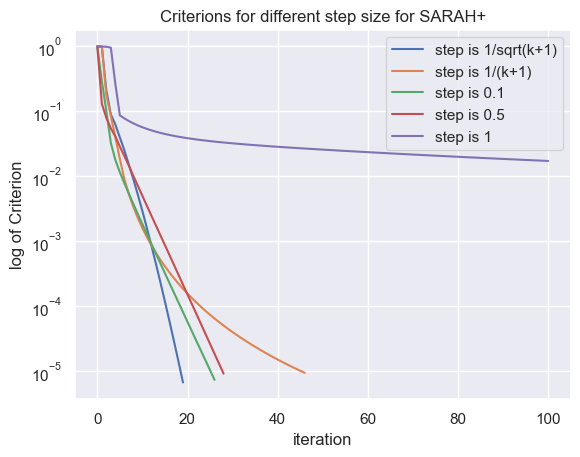

In [151]:
args = {
    "type" : "3",
    "accuracy" : True
}
_, errors3, accuracies3, _ = SARAH(X_batches, y_batches, X_train, y_train, x_0, lam, args, K = 100, m = len(X_batches))
args = {
    "type" : "4",
    "accuracy" : True
}
_, errors4, accuracies4, _ = SARAH(X_batches, y_batches, X_train, y_train, x_0, lam, args, K = 100, m = len(X_batches))

consts = [0.1, 0.5, 1]
errors_for_consts = []
for c in consts:
    args = {
        "type" : "const",
        "const": c,
        "accuracy" : True
    }
    _, errors, accuracies, _ = SARAH(X_batches, y_batches, X_train, y_train, x_0, lam, args, K = 100, m = len(X_batches))
    errors_for_consts.append(errors)
    
clear_output()
plt.plot(range(len(errors3)), errors3)
plt.plot(range(len(errors4)), errors4)
plt.plot(range(len(errors_for_consts[0])), errors_for_consts[0])
plt.plot(range(len(errors_for_consts[1])), errors_for_consts[1])
plt.plot(range(len(errors_for_consts[2])), errors_for_consts[2])
plt.legend(["step is 1/sqrt(k+1)", "step is 1/(k+1)", "step is 0.1", "step is 0.5", "step is 1"])
plt.title("Criterions for different step size for SARAH+")
plt.xlabel("iteration")
plt.ylabel("log of Criterion")
plt.yscale("log")

## All methods together

In [152]:
args = {
    "type" : "3",
    "accuracy" : True
}
_, errorsSARAH, accuraciesSARAH, _ = SARAH(X_batches, y_batches, X_train, y_train, x_0, lam, args, K = 100, m = len(X_batches))
_, errorsSVRG, accuraciesSVRG, _ = SVRG(X_batches, y_batches, X_train, y_train, x_0, lam, args, K = 100, M = len(X_batches))
_, errorsSAGA, accuraciesSAGA, _ = SAGA(X_batches, y_batches, X_train, y_train, x_0, lam, args, K = 100)
args = {
    "type" : "const",
    "const": 1,
    "accuracy" : True
}
_, errorsSGD, accuraciesSGD,_ = gradient_descent(X_batches, y_batches, X_train, y_train, f, grad, x_0, lam, args, K = 100)

clear_output()


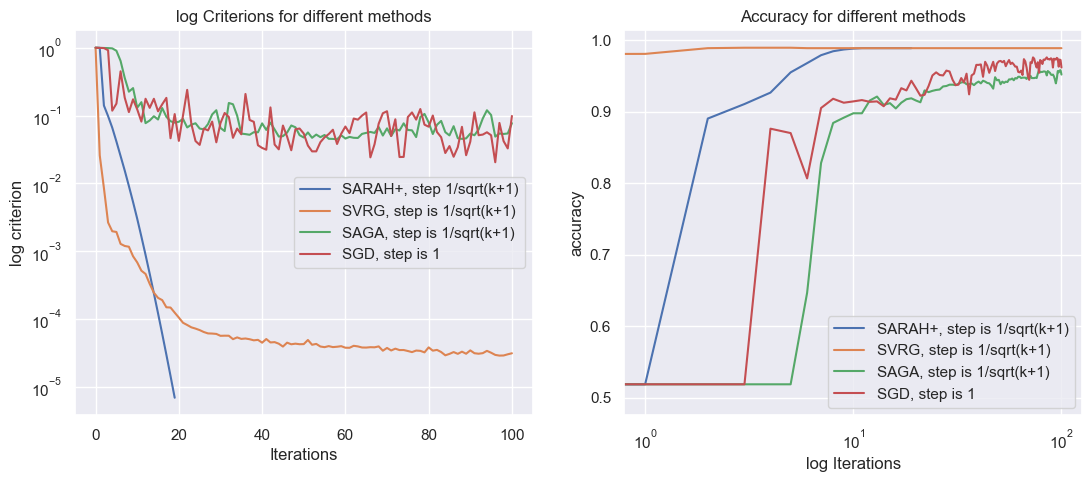

In [156]:
f, axes = plt.subplots(1,2, figsize=(13,5))
axes[0].set_title("log Criterions for different methods")
axes[1].set_title("Accuracy for different methods")
axes[0].set_xlabel("Iterations")
axes[1].set_xlabel("log Iterations")
axes[0].set_yscale("log")
axes[1].set_xscale("log")
axes[0].set_ylabel("log criterion")
axes[1].set_ylabel("accuracy")

axes[0].plot(range(len(errorsSARAH)), errorsSARAH)
axes[1].plot(range(len(accuraciesSARAH)), accuraciesSARAH)
axes[0].plot(range(len(errorsSVRG)), errorsSVRG)
axes[1].plot(range(len(accuraciesSVRG)), accuraciesSVRG)
axes[0].plot(range(len(errorsSAGA)), errorsSAGA)
axes[1].plot(range(len(accuraciesSAGA)), accuraciesSAGA)
axes[0].plot(range(len(errorsSGD)), errorsSGD)
axes[1].plot(range(len(accuraciesSGD)), accuraciesSGD)
axes[0].legend(["SARAH+, step 1/sqrt(k+1)", "SVRG, step is 1/sqrt(k+1)", "SAGA, step is 1/sqrt(k+1)", "SGD, step is 1"])
axes[1].legend(["SARAH+, step is 1/sqrt(k+1)", "SVRG, step is 1/sqrt(k+1)", "SAGA, step is 1/sqrt(k+1)", "SGD, step is 1"])

## Conclusion
Here we clearly see again that SARAH is the best method in our case, since it does not lose its convergence, does not oscillate around optimum(oscillates with less radius), SVRG loses his rate pretty fast, SAGA and SGD are on the same pretty poor level in comparison to SARAH and SVRG, even though they achieve good accuracy at the end.


__Problem 2. (25 points)__ This part of the assignment is related to __distributed with compression__ methods.

Let us simulate a distributed  environment. To do this, divide the training sample randomly and uniformly into $s=10$ parts (this was implemented in Problem 0). 

__а). (5 points)__ Implement the $\text{Rand}k$ and $\text{Top}k$ compression operators, where $k$ is a parameter. 

In [17]:
def randk_compress(vector, k):
    
    d = vector.shape[0]
    ones = np.ones(k)
    zeros = np.zeros(d - k)
    mask = np.concatenate((ones, zeros)).reshape(-1,1)
    np.random.shuffle(mask)
    return vector * mask * d / k

In [18]:
def topk_compress(vector, k):
    
    indices = np.argpartition(vector, -k, axis=0)[-k:]
    mask = np.zeros_like(vector).reshape(-1,1)
    mask[indices] = 1
    return vector * mask

__b). (10 points)__ Implement simple distributed gradient descent with compression operators. Compress information only from the devices to the server. Use compression operators $\text{Rand}1\%$, $\text{Rand}5\%$, $\text{Rand}10\%$, $\text{Rand}20\%$. As in d.2) of Problem 1, find the "best" steps for all cases. Draw the comparison plots with these "best" steps: 1) convergence criterion value versus number of transmitted coordinates from the devices to the server, 2) prediction accuracy versus number of transmitted coordinates from the devices to the server. Make a conclusion.

In [47]:
X_batches, y_batches = divide_into_batches(X_train, y_train, 650)
len(X_batches)

10

In [50]:
def randk_distributed_GD(X_buckets, y_buckets, X_train, y_train, f, nabla_f, x_0, lam, args, k_for_randk, 
                     K = 10**3, eps = 10**-5):
    x_k = x_0.copy()
    norm_grad_at_x_0 = np.linalg.norm(nabla_f(X_train, y_train, x_0, lam))
    errors = [1]
    accuracies = [0.5]
    s = len(y_buckets)
    transmitted_coordinates = [0]
    for k in range(K):
        sum = np.zeros((X_buckets[1].shape[1], 1))
        
        for i in range(s):
            g = nabla_f(X_buckets[i], y_buckets[i], x_k, lam)
            sum += randk_compress(g, k_for_randk)

        
        if args["type"] == "const":
            step = args["const"]
        elif args["type"] == "3":
            step = 1 / math.sqrt(k+1)
        elif args["type"] == "4": 
            step = 1 / (k+1)
        else:
            raise Exception("no such type")
                
        x_k -= step * sum / s
        transmitted_coordinates.append(transmitted_coordinates[-1] + k * k_for_randk)
        
        if args["accuracy"]:
            accuracies.append(calculate_accuracy(X_test, y_test, x_k))
        norm_grad_for_total = np.linalg.norm(nabla_f(X_train, y_train, x_k, lam))
        error = norm_grad_for_total / norm_grad_at_x_0
        errors.append(error)
        if error < eps:
            break
        if error > 4:
            break
    if args["accuracy"]:
        return x_k,transmitted_coordinates, errors, accuracies
    return x_k,transmitted_coordinates, errors

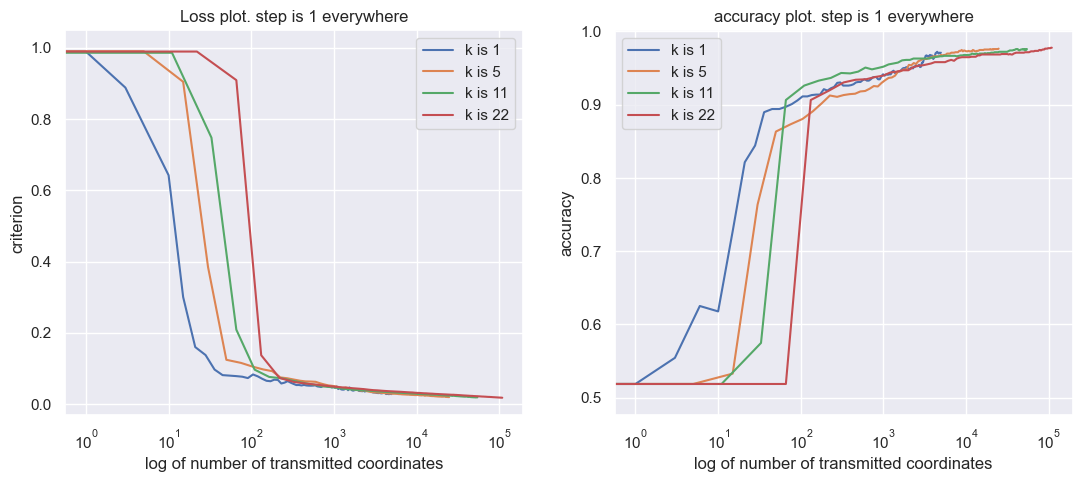

In [55]:
ks=[0.01, 0.05, 0.1, 0.2]
args = {
    "type" : "const",
    "const" : 1,
    "accuracy" : True
}

f, axes = plt.subplots(1,2, figsize=(13,5))
axes[0].set_title("Loss plot. step is 1 everywhere")
axes[1].set_title("accuracy plot. step is 1 everywhere")
axes[0].set_xlabel("log of number of transmitted coordinates")
axes[1].set_xlabel("log of number of transmitted coordinates")
axes[0].set_ylabel("criterion")
axes[1].set_ylabel("accuracy")
axes[0].set_xscale("log")
axes[1].set_xscale("log")

for k in ks:
    _,transmitted_coordinates, losses, accuracies = randk_distributed_GD(X_batches, y_batches, X_train, y_train, f, grad, x_0, lam, args, int(X_batches[1].shape[1] * k),  K = 100)
    assert losses[0] == 1
    axes[0].plot(transmitted_coordinates, losses)
    axes[1].plot(transmitted_coordinates, accuracies)

axes[0].legend(["k is 1","k is 5","k is 11","k is 22"])
axes[1].legend(["k is 1","k is 5","k is 11","k is 22"])

## Conclusion
When I was searching for the best steps, the constant step of size 1 was the best option among all the other for all k.
1. We see that using less components leads to higher variance
3. In case of low number of components to transmit, we see that we converge to the error values faster in terms of number of transmitted coordinates
4. All variants converge well and at some moment they become identical in terms of error and number of transmitted components. => If we transmit less number of components, we have a very good and fast start (in terms of data we transmit) but then we get slowed, and vice versa.

__c). (10 points)__ Now we use $\text{Top}10\%$ as compression operators. Compress the information only from the devices to the server. Use two methods: regular distributed gradient descent with compression operators, and distributed gradient descent with error feedback technique (see Algorithm 1 from [article](https://arxiv.org/abs/2002.12410)). For each method, select the step for the "best" convergence. Draw the comparison plots with these "best" steps: 1) convergence criterion value versus number of transmitted coordinates from the devices to the server, 2) prediction accuracy versus number of transmitted coordinates from the devices to the server. Make a conclusion.

In [16]:
X_batches, y_batches = divide_into_batches(X_train, y_train, 650)
len(X_batches)

10

In [27]:
def topk_distributed_GD(X_buckets, y_buckets, X_train, y_train, f, nabla_f, x_0, lam, args, k_for_topk, 
                     K = 10**3, eps = 10**-5):
    x_k = x_0.copy()
    norm_grad_at_x_0 = np.linalg.norm(nabla_f(X_train, y_train, x_0, lam))
    errors = [1]
    accuracies = [0.5]
    transmitted_coordinates = [0]
    s = len(y_buckets)
    L_for_workers = [calculate_L_for_batch(X_buckets[worker], lam) for worker in range(s)]
    for k in range(K):
        if args["type"] == "const":
            step = args["const"]
        elif args["type"] == "3":
            step = 1 / math.sqrt(k+1)
        elif args["type"] == "4": 
            step = 1 / (k+1)
        elif args["type"] != "L":
            raise Exception("no such type")
            
        sum = np.zeros((X_buckets[1].shape[1], 1))
        
        for i in range(s):
            
            if args["type"] == "L":
                step = 1 / L_for_workers[i]
                
            g = nabla_f(X_buckets[i], y_buckets[i], x_k, lam)
            sum += topk_compress(g, k_for_topk)
                
        x_k -= step * sum / s
        transmitted_coordinates.append(transmitted_coordinates[-1] + k * k_for_topk)
    
        if args["accuracy"]:
            accuracies.append(calculate_accuracy(X_test, y_test, x_k))
        norm_grad_for_total = np.linalg.norm(nabla_f(X_train, y_train, x_k, lam))
        error = norm_grad_for_total / norm_grad_at_x_0
        errors.append(error)
        if error < eps:
            break
        if error > 4:
            break
    if args["accuracy"]:
        return x_k, transmitted_coordinates, errors, accuracies
    return x_k, transmitted_coordinates,  errors

In [44]:
def topk_distributed_GD_with_error(X_buckets, y_buckets, X_train, y_train, f, nabla_f, x_0, lam, args, k_for_topk, 
                     K = 10**3, eps = 10**-5):
    x_k = x_0.copy()
    norm_grad_at_x_0 = np.linalg.norm(nabla_f(X_train, y_train, x_0, lam))
    errors = [1]
    accuracies = [0.5]
    transmitted_coordinates = [0]
    s = len(y_buckets)
    memory = np.zeros((s, X_buckets[1].shape[1], 1))
    L_for_workers = [calculate_L_for_batch(X_buckets[worker], lam) for worker in range(s)]
    for k in range(K):
        if args["type"] == "const":
            step = args["const"]
        elif args["type"] == "3":
            step = 1 / math.sqrt(k+1)
        elif args["type"] == "4": 
            step = 1 / (k+1)
        elif args["type"] != "L":
            raise Exception("no such type")

        
        sum = np.zeros((X_buckets[1].shape[1], 1))
        
        for worker in range(s):
            if args["type"] == "L":
                step = 1 / L_for_workers[worker]
                
            grad = nabla_f(X_buckets[worker], y_buckets[worker], x_k, lam)
            g = step * grad + memory[worker]
            g = topk_compress(g, k_for_topk)
            memory[worker] = memory[worker] + step * grad - g
            sum += g

                
        x_k -= sum / s
        transmitted_coordinates.append(transmitted_coordinates[-1] + k * k_for_topk)
    
        if args["accuracy"]:
            accuracies.append(calculate_accuracy(X_test, y_test, x_k))
            
        norm_grad_for_total = np.linalg.norm(nabla_f(X_train, y_train, x_k, lam))
        error = norm_grad_for_total / norm_grad_at_x_0
        errors.append(error)
        if error < eps:
            break
        if error > 4:
            break
    if args["accuracy"]:
        return x_k, transmitted_coordinates, errors, accuracies
    return x_k, transmitted_coordinates,  errors

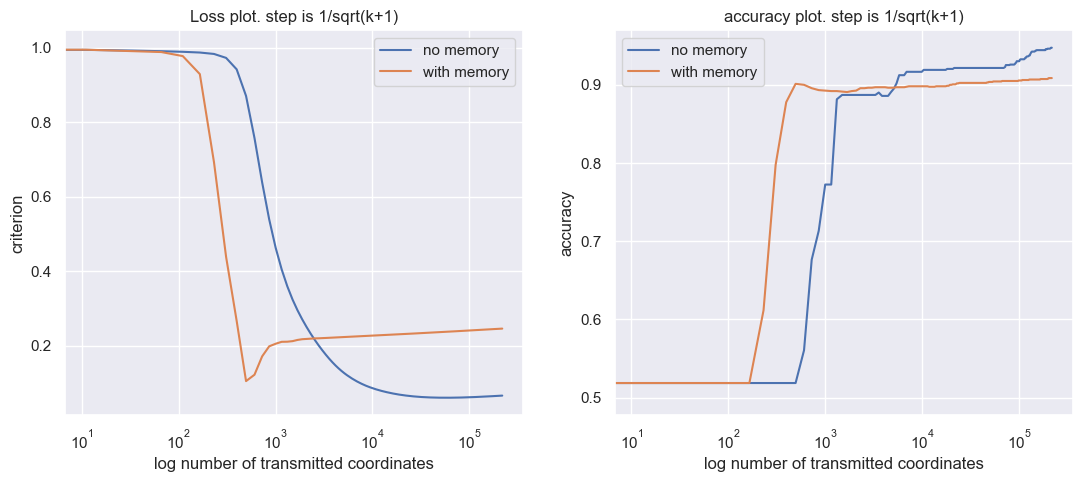

In [46]:
k=0.1
args = {
    "type" : "3",
    "accuracy" : True
}

f, axes = plt.subplots(1,2, figsize=(13,5))
axes[0].set_title("Loss plot. step is 1/sqrt(k+1)")
axes[1].set_title("accuracy plot. step is 1/sqrt(k+1)")
axes[0].set_xlabel("log number of transmitted coordinates")
axes[1].set_xlabel("log number of transmitted coordinates")
axes[0].set_ylabel("criterion")
axes[1].set_ylabel("accuracy")
axes[0].set_xscale("log")
axes[1].set_xscale("log")

_,transmitted_coordinates, losses, accuracies = topk_distributed_GD(X_batches, y_batches, X_train, y_train, f, grad, x_0, lam, args, int(X_batches[1].shape[1] * k),  K = 200)
axes[0].plot(transmitted_coordinates, losses)
axes[1].plot(transmitted_coordinates, accuracies)
_,transmitted_coordinates, losses, accuracies = topk_distributed_GD_with_error(X_batches, y_batches, X_train, y_train, f, grad, x_0, lam, args, int(X_batches[1].shape[1] * k),  K = 200)
axes[0].plot(transmitted_coordinates, losses)
axes[1].plot(transmitted_coordinates, accuracies)


axes[0].legend(["no memory","with memory"])
axes[1].legend(["no memory","with memory"])

## Conclusion
1. The best result was achieved by step size $\frac{1}{\sqrt{k+1}}$.
2. The method with memory converges faster, but achieves a little bit worse result
3. Both methods start to diverge

__Problem 3. (15 points)__ This part of the assignment is related to __distributed with local steps__ methods.

As in the previous problem we simulate the distributed enviroment with $s = 10$. Implement simple Local GD/FedAvg method (Algorithm 1 of [paper](https://arxiv.org/pdf/1909.04746.pdf)), where you can choose the number of local steps $H$ as a parameter. Vary the number of local steps: $H = 1, 5, 10, 20$. Take hyperparameters of the method according to the theory (see the corresponding paper). Write these parameters. Draw the comparison plots for different $H$: 1) value of convergence criterion versus number of communications, 2) accuracy of predictions versus number of communications. Make a conclusion.

## Hyperparameters
Note that everything is written under the assumption the we use identical data in case of our problem.\
We have 2 hyperparameters for the method: number of local steps H and learning rate.\
H is varied by us\
the learning rate is chosen to be $\frac{1}{L}$, because:
1. In case of identical data for workers, there are the theorems about convergence and all of them hold for the lr equal to $\frac{1}{L}$
2. Authors of the paper experimented on logistic regression task using $\frac{1}{L}$ learning rate, as well as $\frac{0.5}{L}$, and for both there is the convergence.
Therefore, I decided lr $\frac{1}{L}$ is the good option

In [30]:
X_batches, y_batches = divide_into_batches(X_train, y_train, 650)
len(X_batches)

10

In [104]:
def local_gd(X_buckets, y_buckets, X_train, y_train, f, nabla_f, x_0, lam, H, args,
                     t = 10**3, eps = 10**-4):
    assert (t+1) % H == 0, "last step is not global synchonization"
    s = len(y_buckets)
    x_k_for_workers = np.repeat(x_0.T, s, axis=0).reshape(s, -1, 1)
    L_for_workers = [calculate_L_for_batch(X_buckets[worker], lam) for worker in range(s)]
    
    norm_grad_at_x_0 = np.linalg.norm(nabla_f(X_train, y_train, x_0, lam))
    errors = [1]
    accuracies = []
    for t in tqdm(range(t)):
            
        for worker in range(s):
            local_n = X_buckets[worker].shape[0]
            sampled_i = random.randint(0, local_n-1)
            g = nabla_f(X_batches[worker][sampled_i].reshape(1,-1), y_batches[worker][sampled_i].reshape(1,-1), x_k_for_workers[worker], lam)
            
            step = 1 / L_for_workers[worker]
            
            x_k_for_workers[worker] -= step * g
            
        if (t+1) % H == 0: # averaging
            av = np.mean(x_k_for_workers, axis=0)
            x_k_for_workers = np.repeat(av, s, axis=0).reshape(s, -1, 1)
            if args["accuracy"]:
                accuracies.append(calculate_accuracy(X_test, y_test, av))
                
            norm_grad_for_total = np.linalg.norm(nabla_f(X_train, y_train, av, lam))
            error = norm_grad_for_total / norm_grad_at_x_0
            errors.append(error)
            if error < eps:
                break
            if error > 4:
                break
            
    if args["accuracy"]:
        return av, errors, accuracies
    return av, errors  

100%|█████████████████████████████████████████████████████████████████████████████| 3999/3999 [00:10<00:00, 389.76it/s]


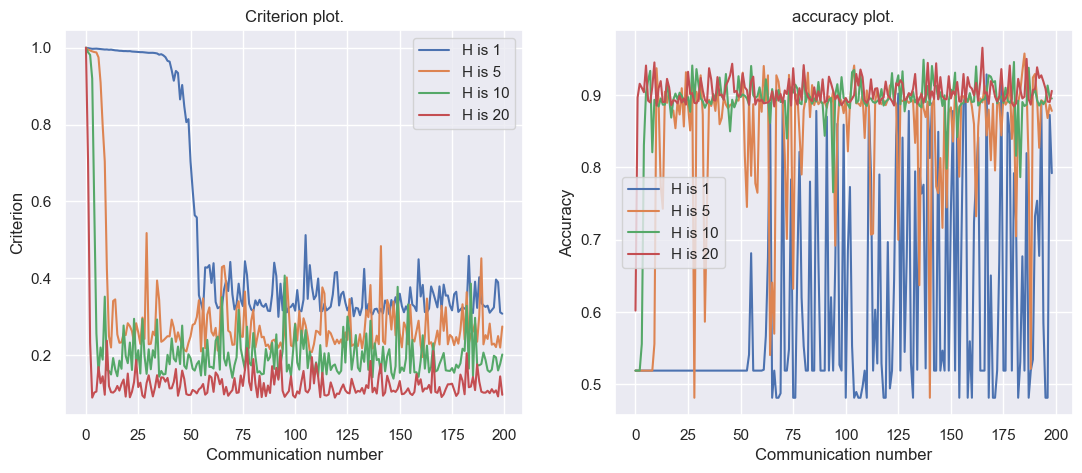

In [112]:
f, axes = plt.subplots(1,2, figsize=(13,5))
axes[0].set_title("Criterion plot.")
axes[1].set_title("accuracy plot.")
axes[0].set_xlabel("Communication number")
axes[1].set_xlabel("Communication number")
axes[0].set_ylabel("Criterion")
axes[1].set_ylabel("Accuracy")

args = {
    "accuracy" : True
}
for pair in [(1, 200),(5, 1000),(10, 2000),(20, 4000)]:
    _, errors, accuracies = local_gd(X_batches, y_batches, X_train, y_train, f, grad, x_0, lam, pair[0], args, pair[1]-1)
    axes[0].plot(range(len(errors)), errors)
    axes[1].plot(range(len(accuracies)), accuracies)
    
axes[0].legend(["H is 1","H is 5","H is 10","H is 20"])
axes[1].legend(["H is 1","H is 5","H is 10","H is 20"])

## Conclusion
1. We see that in all cases we have equal variance in terms of Criterion
2. lower value of H - higher variance of accuracy we have
3. Using higher values of H we obtain better results in terms of criterion and accuracy, that we cannot achieve using smaller H.
4. We use much less number of communications to converge a neighborhood of the optimum for higher values of H